In [37]:
import matplotlib.pyplot as plt
import keras
import random
import numpy as np
from sklearn import metrics
import seaborn as sns
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import pandas as pd
from sklearn.preprocessing import LabelBinarizer

In [38]:
retrain = False

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = [20, 15]

train_df = pd.read_csv("data/sign_mnist_train.csv")
test_df = pd.read_csv("data/sign_mnist_test.csv")

In [39]:
classes = pd.unique(train_df.label)
train_num_samples = len(train_df)
test_num_samples = len(test_df)
print(f'Training Samples: {train_num_samples}')
print(f'Training Samples: {test_num_samples}')
print(f'Classes: {classes}')

Training Samples: 27455
Training Samples: 7172
Classes: [ 3  6  2 13 16  8 22 18 10 20 17 19 21 23 24  1 12 11 15  4  0  5  7 14]


In [40]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [41]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

x_train = train_df.values
x_test = test_df.values

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(27455, 28, 28, 1)
(27455, 24)
(7172, 28, 28, 1)
(7172, 24)


In [42]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [43]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 75)        750       
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 75)       300       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 75)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_7 (Batc  (None, 14, 14, 50)      

In [44]:
if retrain:
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)
    history = model.fit(datagen.flow(x_train,y_train, batch_size = 64) ,epochs = 50 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])
    model.save('american_dataset.h5')
    history = pd.DataFrame(history.history)
    history.to_csv("america_history.csv")
else:
    model = load_model('american_dataset.h5')
    history = pd.read_csv("german_history.csv")

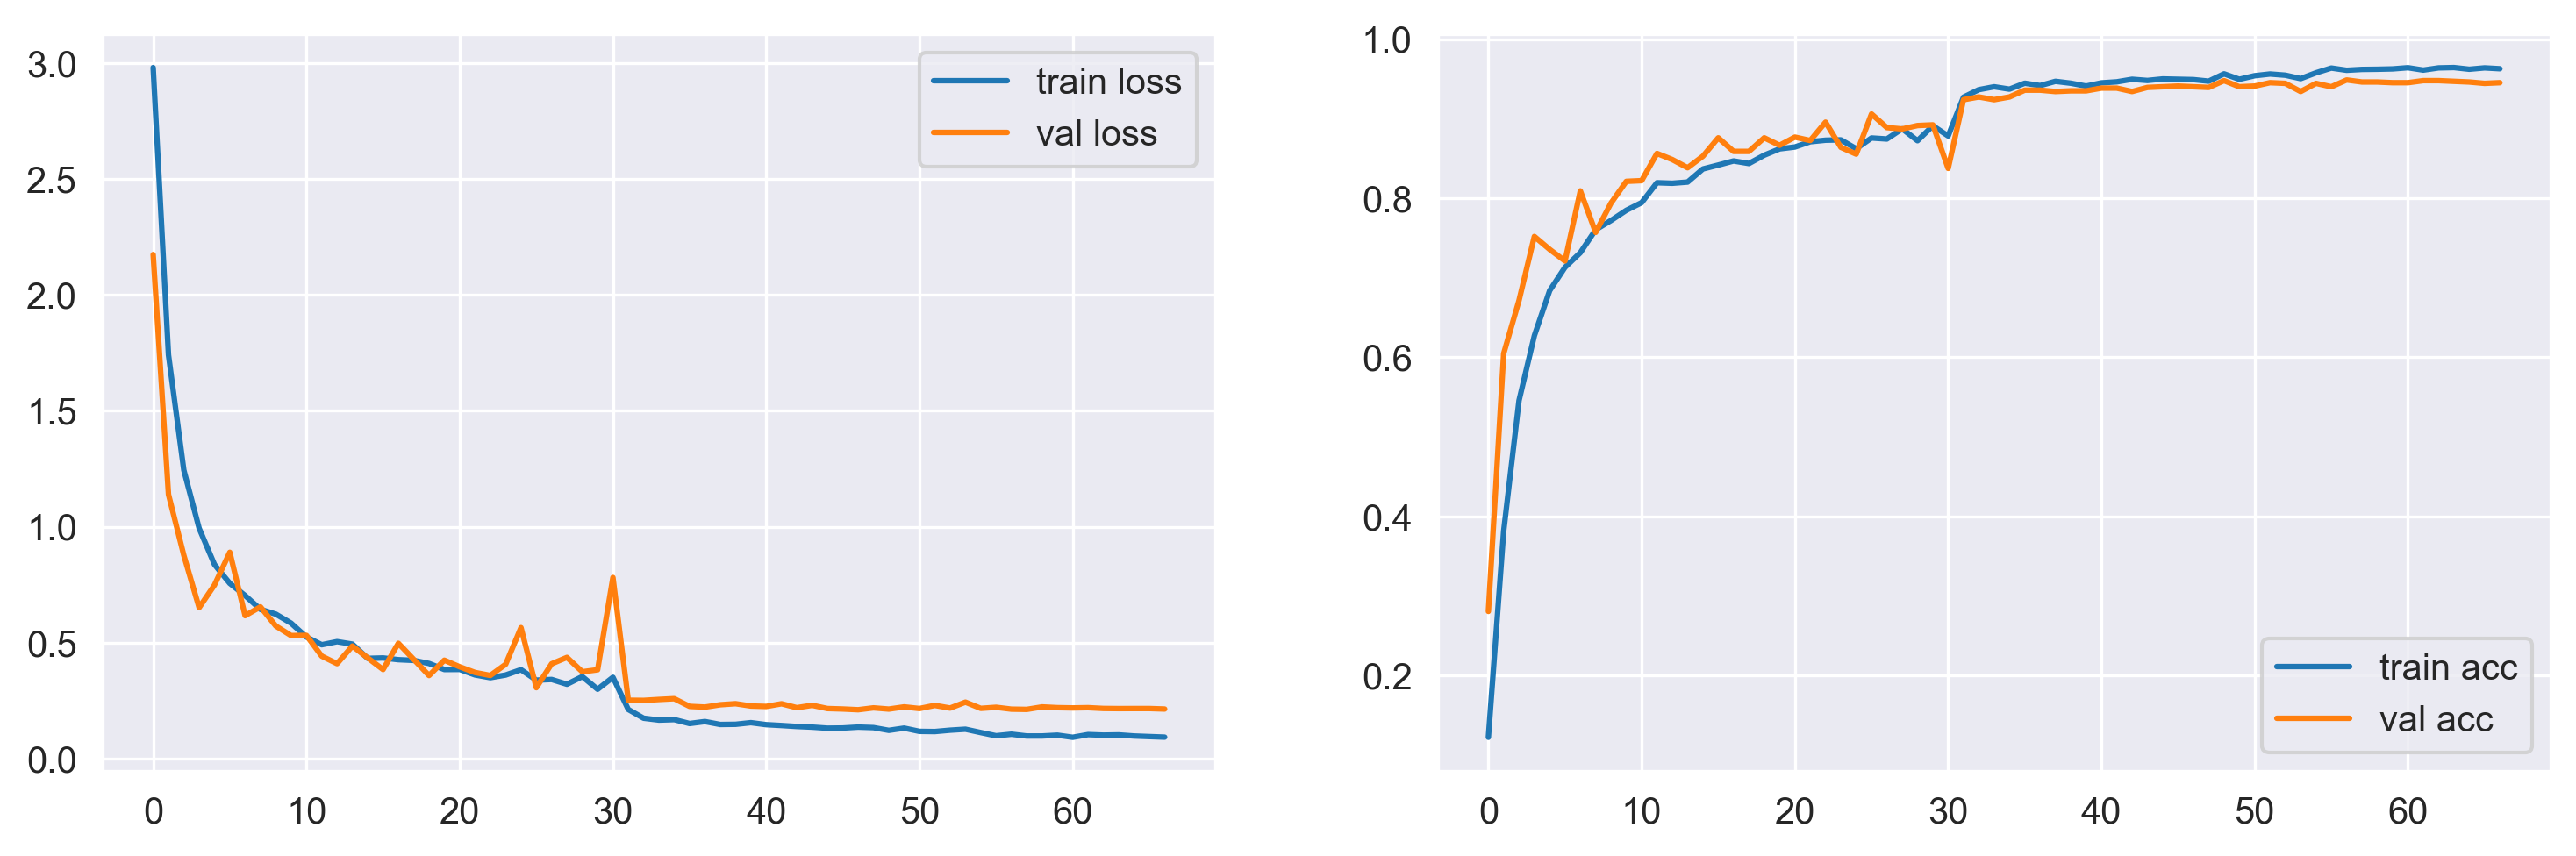

In [47]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.legend()

plt.subplot(2, 2, 2)
if retrain:
    plt.plot(history['accuracy'], label='train acc')
    plt.plot(history['val_accuracy'], label='val acc')
else:
    plt.plot(history['acc'], label='train acc')
    plt.plot(history['val_acc'], label='val acc')
plt.legend()

In [49]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f'*'*11 + "Test data" + 11*"*" +f"\nloss={loss:.10f} acc={acc:.10f}")

***********Test data***********
loss=0.0010234232 acc=0.9998605847


225/225 [==============================] - 4s 16ms/step


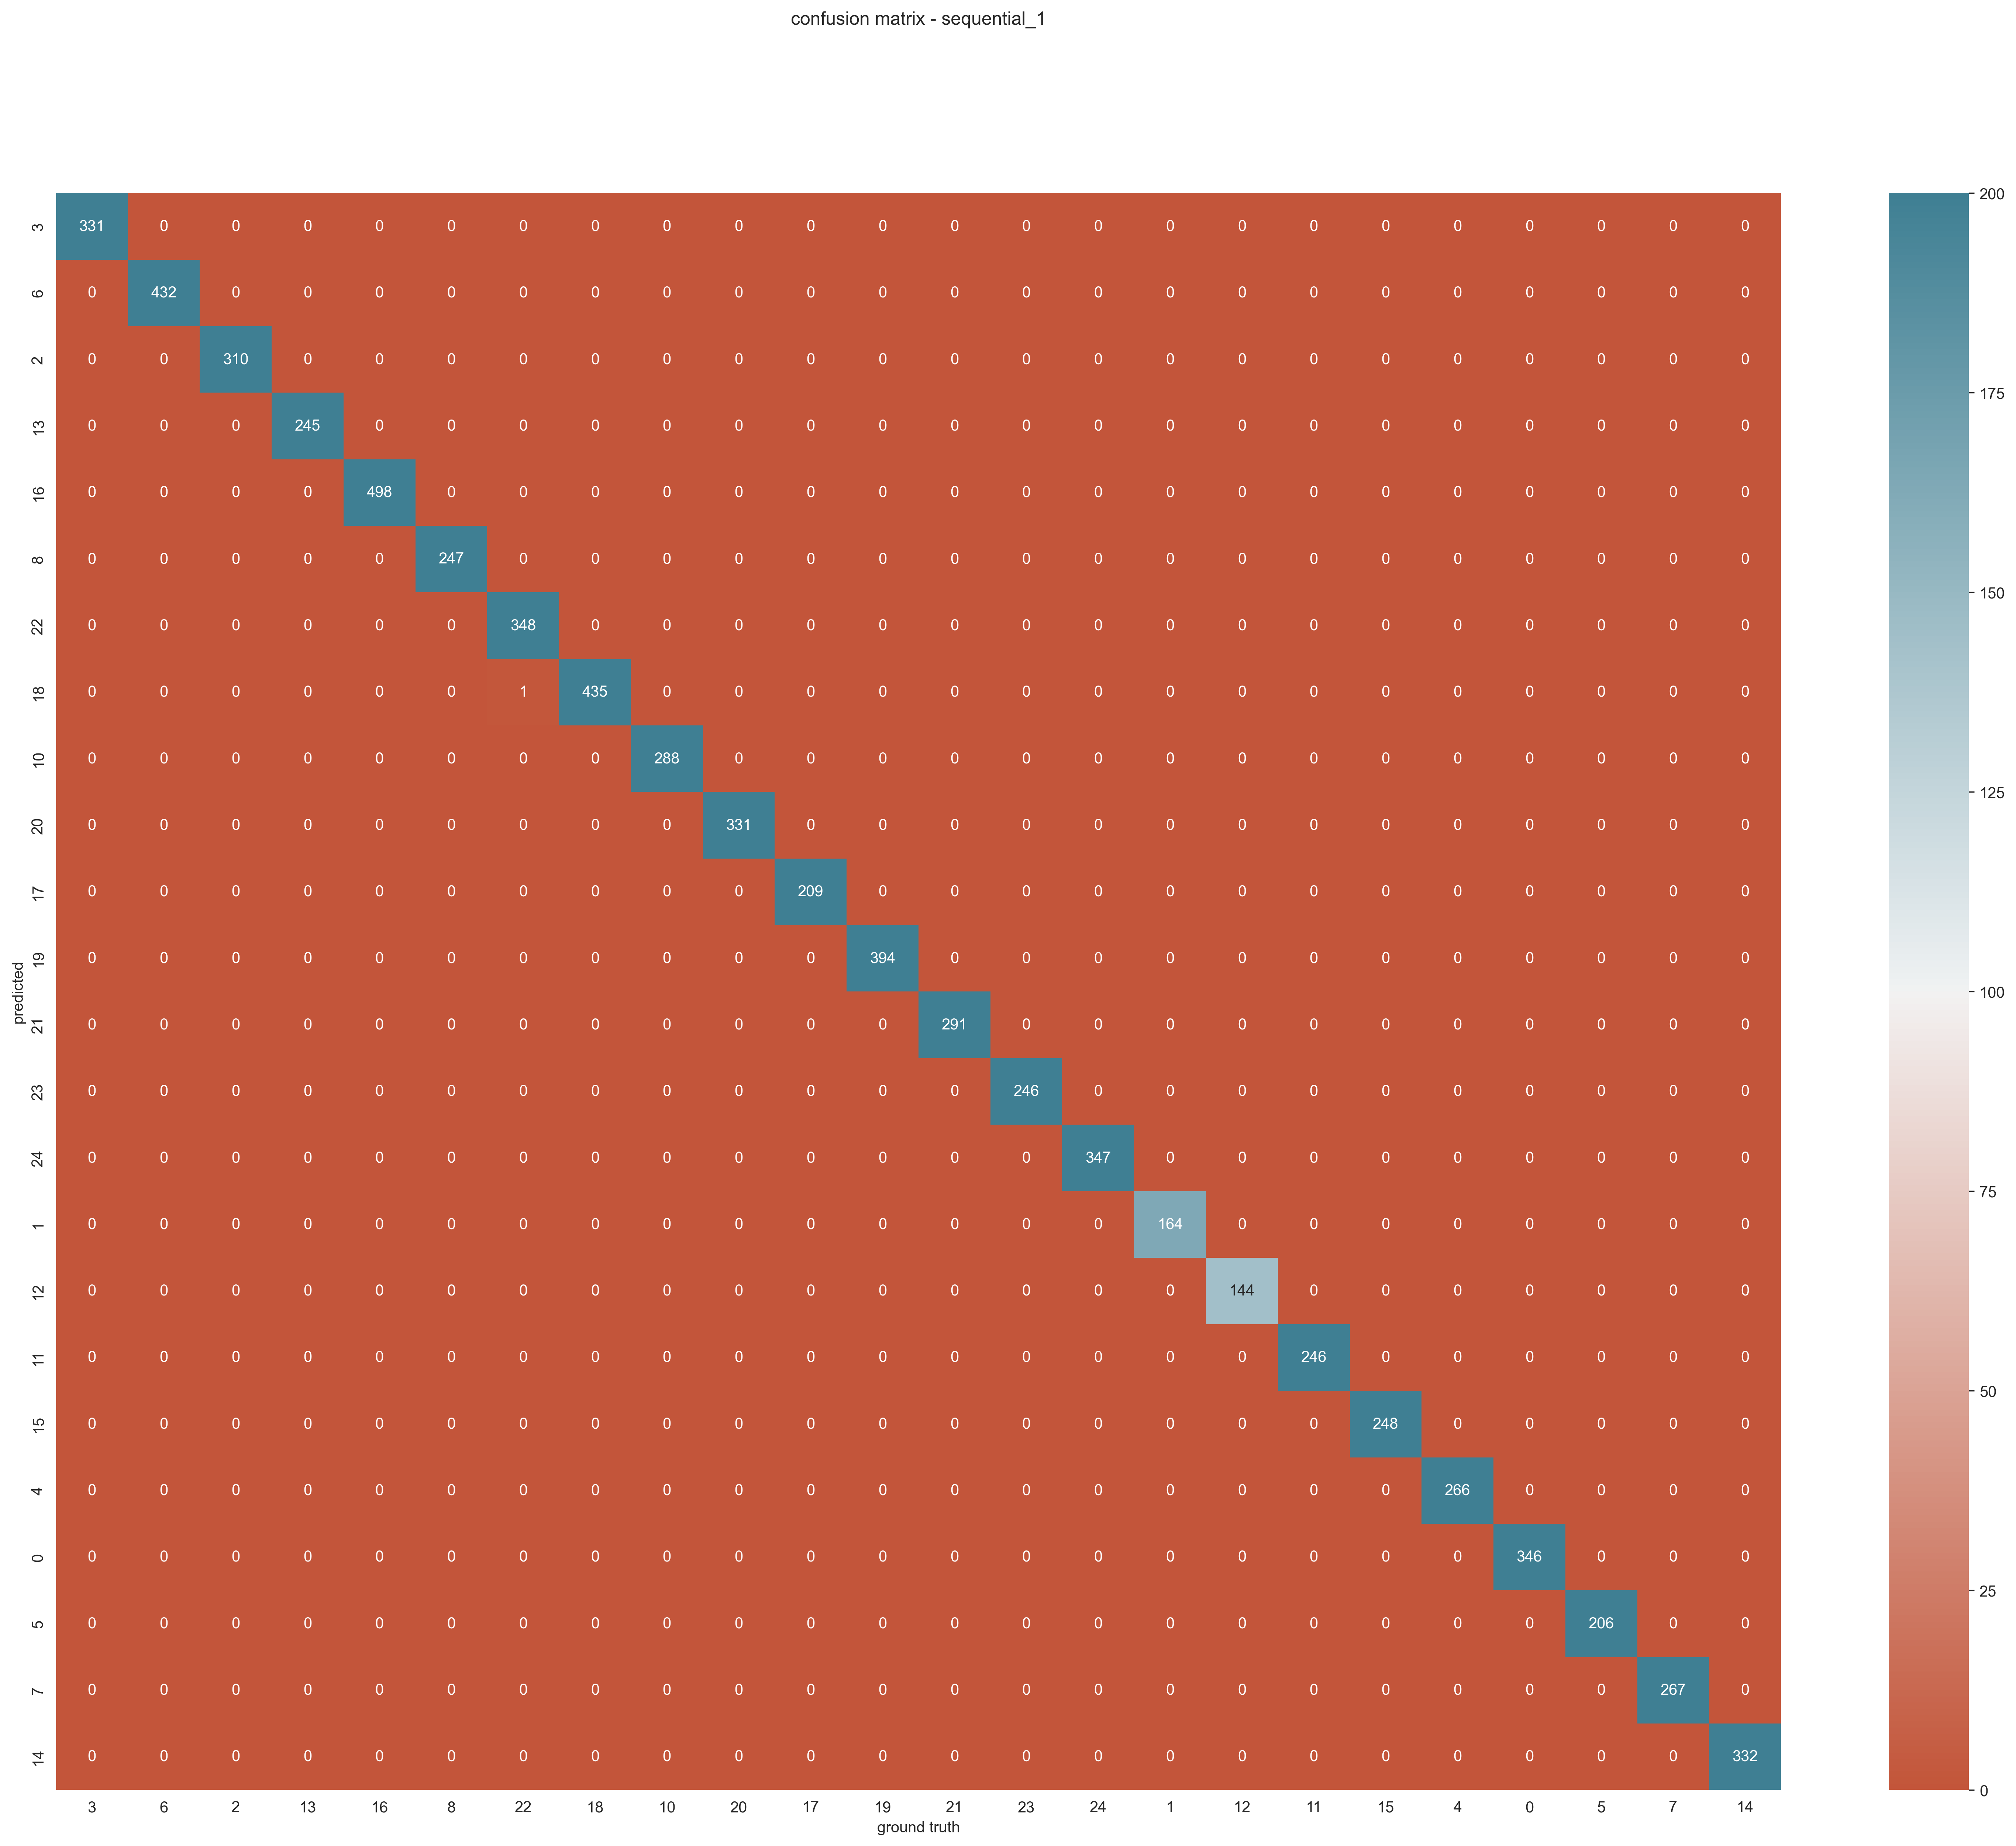

In [57]:
predictions = model.predict(x_test)
prediction_classes = np.argmax(predictions, axis=-1)

gt_classes = np.argmax(y_test, axis=-1)
confusion_matrix = metrics.confusion_matrix(gt_classes, prediction_classes)
cmap = sns.diverging_palette(20, 220, as_cmap=True)
sns.heatmap(pd.DataFrame(confusion_matrix, index=classes, columns=classes), annot=True, cmap=cmap, fmt='d', vmax=200)
plt.tight_layout()
plt.title('Confusion Matrix for a predicting the American Sign Language')
plt.ylabel('predicted')
plt.xlabel('ground truth')
plt.show()

In [51]:
amount_of_samples = 12

# Pick 10 random images for test data set
random.seed(3) # to make this deterministic
sample_indexes = random.sample(range(len(x_test)), amount_of_samples)
sample_images = [x_test[i] for i in sample_indexes]
sample_labels = [y_test[i] for i in sample_indexes]

ground_truth = np.argmax(sample_labels, axis=1)

X_sample = np.array(sample_images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
predicted_categories

1/1 [==============================] - 0s 24ms/step


array([14, 12,  1, 19, 15, 22, 20, 22, 13, 17,  3, 13])

In [52]:
# Display the predictions and the ground truth visually.

def display_prediction (images, true_labels, predicted_labels):
    fig = plt.figure(figsize=(20, amount_of_samples +10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(amount_of_samples, 4,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(30, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction),
                 fontsize=12, color=color)
        plt.imshow(images[i])


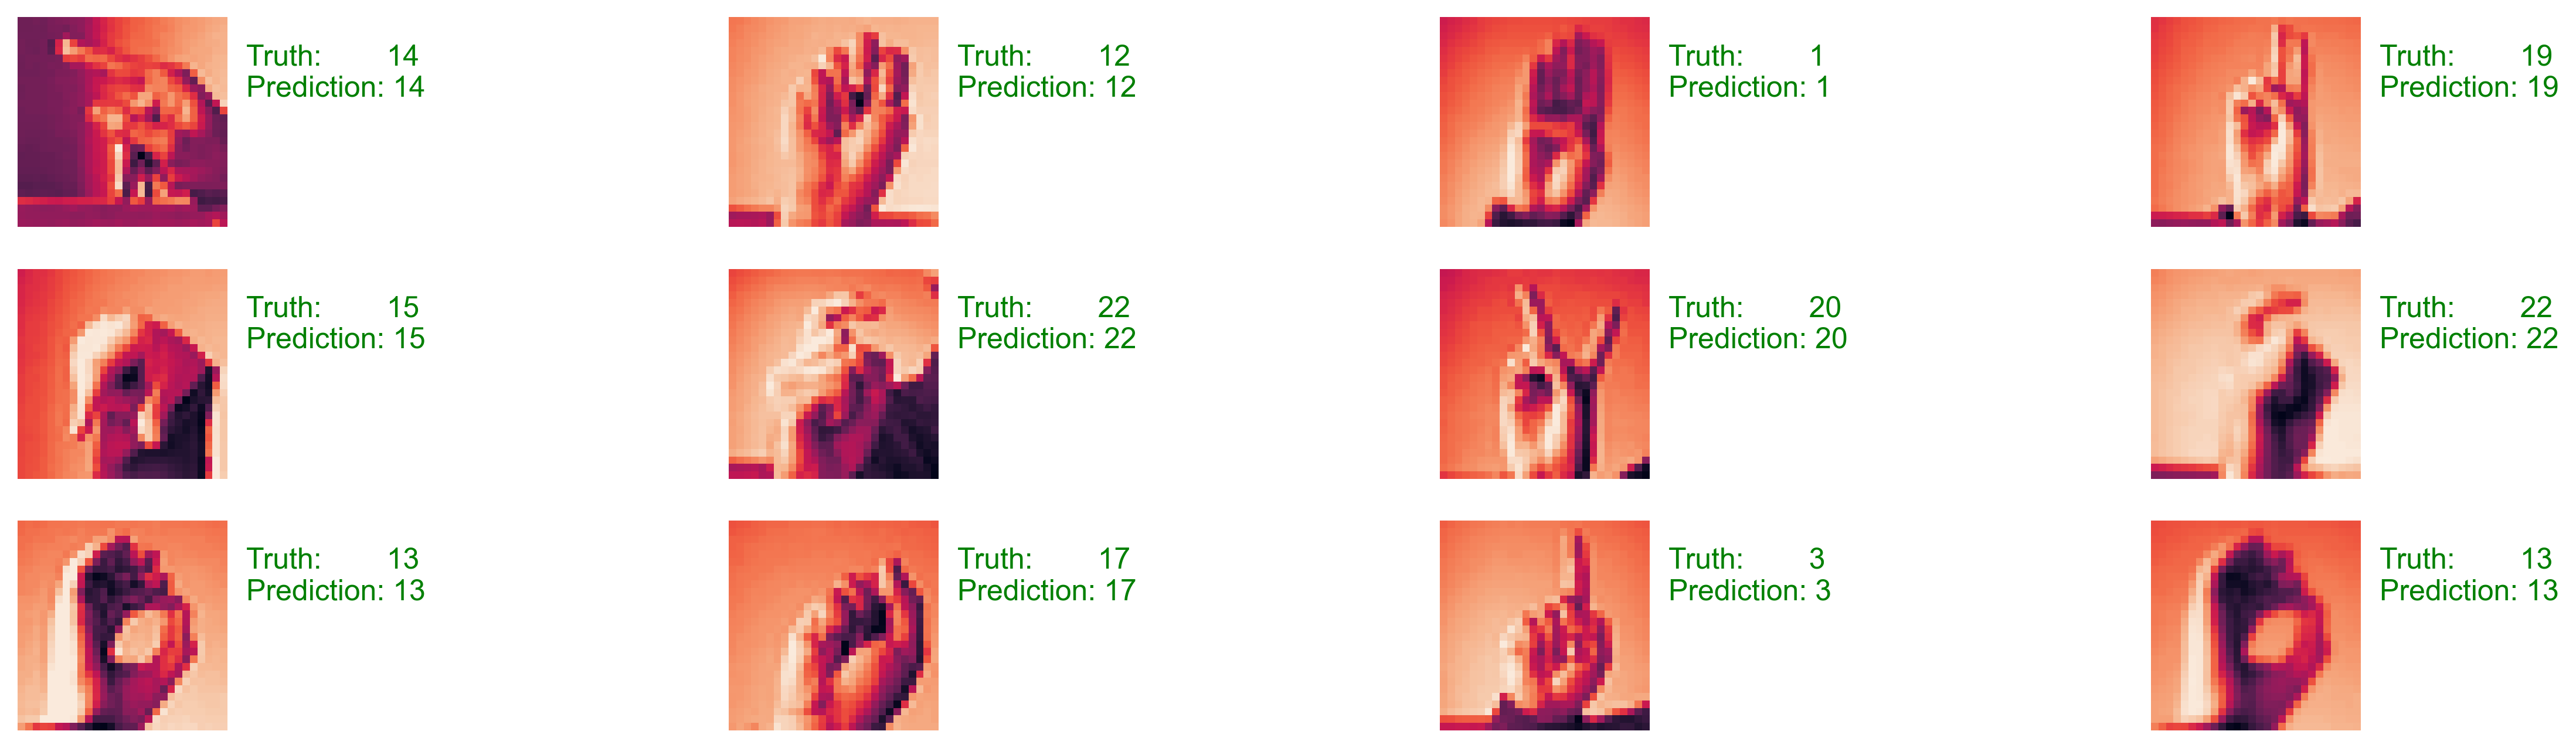

In [53]:
display_prediction(sample_images, ground_truth, predicted_categories)

In [54]:
ground_truth, predicted_categories

(array([14, 12,  1, 19, 15, 22, 20, 22, 13, 17,  3, 13]),
 array([14, 12,  1, 19, 15, 22, 20, 22, 13, 17,  3, 13]))